In [196]:
import pandas as pd
import wandb

import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
sns.set_style("white", {"grid.color": ".6", "grid.linestyle": ":"})

In [197]:
pd.set_option('display.max_rows', 100)

In [220]:
from  matplotlib.colors import LinearSegmentedColormap

c = ["darkred", "firebrick", "red", "lightcoral", "palegreen", "lime", "green","darkgreen"]

v = [0,.15, 0.25,.4,0.6,0.8,.98,1.]
l = list(zip(v,c))

CMAP = LinearSegmentedColormap.from_list('rg',l, N=256)

---

In [222]:
def get_runs_df(project, entity="jurujin", resolution=False):
    api = wandb.Api()
    runs = api.runs(entity + "/" + project)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)


    summary_df = pd.DataFrame(summary_list)
    config_df = pd.DataFrame(config_list)

    df = pd.concat([summary_df.reset_index(drop=True), config_df.reset_index(drop=True)], axis=1)
    df["name"] = name_list
    if resolution:
        df["det_resol"] = df["no_w_det_dist_mean"] - df["w_det_dist_mean"]

    return df.sort_values(by=["w_radius", "msg_scaler"])

In [223]:
projects = [
    "msg_long_detect_no_att",
    "msg_grid_srch",    # V
    "msg_diff_att",     # V
    "msg_all_attacks",      # V
    "fid_msg_grid_srch_gen",    # doing 1 run for r=4 s=60
    "fid_msg_grid_srch_gt",     # V
    "fid_msg_r_gen",    # V
    "fid_msg_r_gt"      # V
]

detection_projects = [
    "msg_long_detect_no_att",
    "msg_grid_srch",    # V
    "msg_diff_att",     # V
    "msg_all_attacks"
]

fid_projects = [
    "fid_msg_grid_srch_gen",    # doing 1 run for r=4 s=60
    "fid_msg_grid_srch_gt",     # V
    "fid_msg_r_gen",
    "fid_msg_r_gt"
]

detection_cols = [
    "TPR@1%FPR", "acc", "auc",
    "Bit_acc", "Word_acc",
    "det_resol",

    "w_clip_score_mean",

    "w_det_dist_mean",
    "no_w_det_dist_mean",

    "w_det_dist_std",
    "no_w_det_dist_std",
    
    "msg", "w_radius", "msg_scaler",

    "jpeg_ratio", "crop_scale", "crop_ratio", "gaussian_blur_r", "gaussian_std", "brightness_factor", "r_degree"
]

fid_cols = [
    "psnr_w", "ssim_w",
    "psnr_no_w", "ssim_no_w",
    "fid_w", "fid_no_w",
    "msg", "w_radius", "msg_scaler",

]

In [224]:
for project in detection_projects:
    get_runs_df(project, resolution=True).to_csv(f"./detection/{project}.csv", index=False, columns=detection_cols)

for project in fid_projects:
    get_runs_df(project).to_csv(f"./fid/{project}.csv", index=False, columns=fid_cols)

---
## Plotting grid search tests:

In [270]:
def plot_grid_search(project, metric_name, figsize=(10, 8), x_ticks_step=5, y_ticks_step=10, azim=20, elev=45, zoom=0.95):
    '''
    str metric_name: Name of the target column
    '''
    df = get_runs_df(project)

    scaler = df["msg_scaler"]
    radius = df["w_radius"]
    metric = df[metric_name]

    scaler_num = scaler.nunique()
    radius_num = radius.nunique()

    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(figsize, forward=True)

    # surf = ax.plot_surface(s, r, z, linewidth=0, antialiased=False)

    X = radius.values.reshape(radius_num, scaler_num)
    Y = scaler.values.reshape(radius_num, scaler_num)
    Z = metric.values.reshape(radius_num, scaler_num)

    surf = ax.plot_surface(X, Y, Z, cmap=CMAP, alpha=0.8)

    ax.set_xlabel('Radius', fontsize=12)
    ax.set_ylabel('Scaler', fontsize=12)
    ax.set_zlabel(metric_name.replace("_", " "), fontsize=12)

    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect(zoom=zoom, aspect=None)

    ax.scatter(radius, scaler, metric, s=50, c="black", alpha=0.5)

    plt.xticks(np.arange(0, np.max(X) + x_ticks_step, x_ticks_step))
    plt.yticks(np.arange(np.min(Y), np.max(Y) + y_ticks_step, y_ticks_step))

    # Add color bar
    fig.colorbar(surf, shrink=0.4, aspect=8)

    # fig.suptitle(metric_name.replace("_", " "), y=0.8)


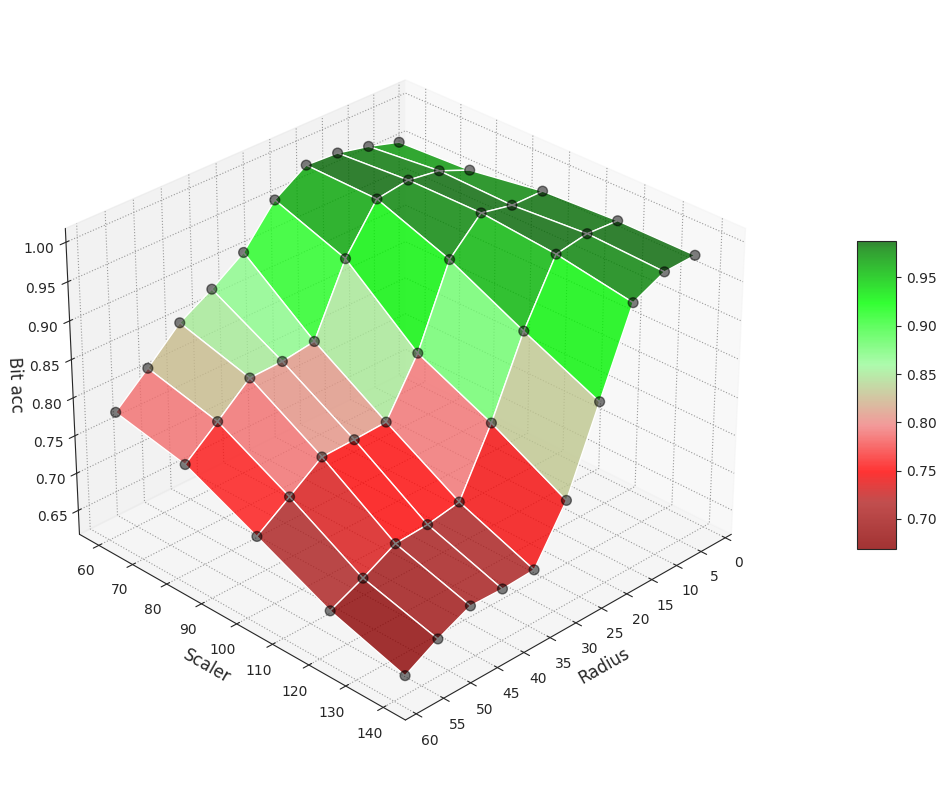

In [271]:
plot_grid_search(
    "msg_grid_srch",
    metric_name="Bit_acc",
    elev=30,
    azim=45,
    figsize=(20, 10)
)

# plt.savefig("bit_acc_grid.png")

In [317]:
def grid_search_table(project, metric_name, figsize=(10, 8)):
    '''
    str metric_name: Name of the target column
    '''
    df = get_runs_df(project)

    scaler = df["msg_scaler"]
    radius = df["w_radius"]
    metric = df[metric_name]

    scaler_num = scaler.nunique()
    radius_num = radius.nunique()

    
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize, forward=True)

    # surf = ax.plot_surface(s, r, z, linewidth=0, antialiased=False)

    X = radius.values.reshape(radius_num, scaler_num)
    Y = scaler.values.reshape(radius_num, scaler_num)
    Z = metric.values.reshape(radius_num, scaler_num)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    table = plt.pcolor(X, Y, Z, cmap=CMAP, alpha=0.7)

    for i in range(radius_num):
        for j in range(scaler_num):
            plt.text(X[i, j], Y[i, j], f'{Z[i, j]:.3f}', ha='center', va='center', color='black')

    plt.xticks(radius.unique())
    plt.yticks(scaler.unique())

    ax.set_xlabel('Radius', fontsize=12)
    ax.set_ylabel('Scaler', fontsize=12)

    fig.colorbar(table)
    
    # plt.suptitle(metric_name.replace("_", " ").capitalize(), x=0.43, fontsize=16, y=0.95)

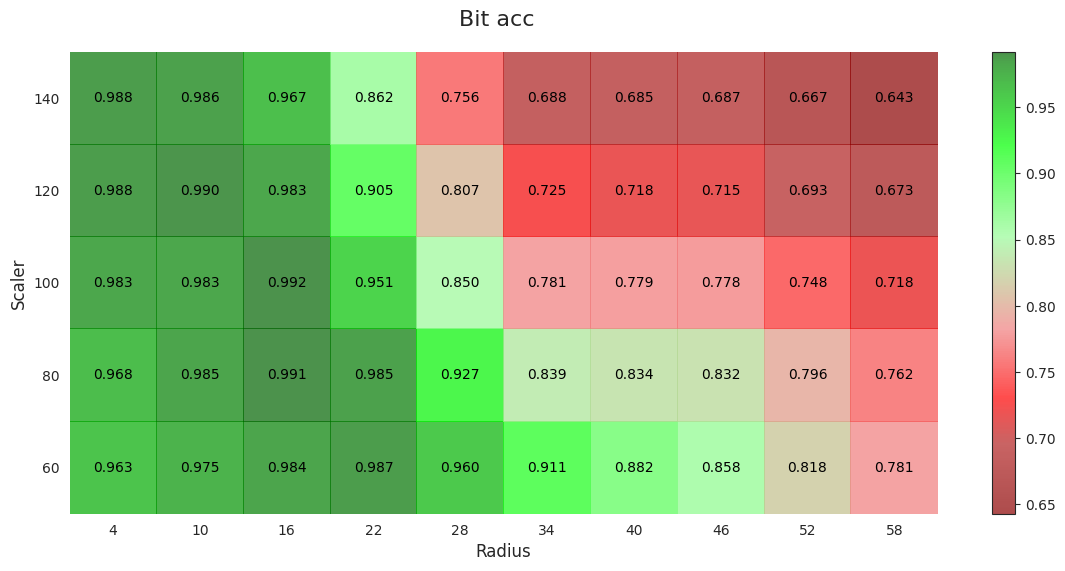

In [318]:
grid_search_table(
    "msg_grid_srch",
    metric_name="Bit_acc",
    figsize=(14, 6)
)

# plt.savefig("bit_acc_grid.png")